# Predictive Maintenance System for Equipment

Tech companies maintain large networks of devices (servers, routers, and IoT devices). The goal of the project is to predict failures to reduce downtime, save costs, and ensure better service.

This a real-world solution that will use synthetic data (which could easily be replaced with real data) for the creation of the model.

The predictive maintenance system will use Machine Learning tools including Random Forests and XGBoost. It predicts the likelihood of device failure based on historical data (temperature, voltage, and performance metrics).

In [35]:
# Generating data

import numpy as np
import pandas as pd
import random
import datetime

# Parameters
n_devices = 50  # Number of devices (assumes 
n_days = 365  # Number of days
readings_per_day = 24  # Hourly readings

# Failure conditions
def generate_failure_conditions(temperature, vibration, pressure, operating_hours):
    # Failure if temperature > 80, vibration > 10, and pressure > 30 after 1000 operating hours
    if temperature > 80 and vibration > 10 and pressure > 30 and operating_hours > 1000:
        return 1
    else:
        return 0

def generate_synthetic_data(n_devices, n_days, readings_per_day):
    data = []
    
    for device in range(n_devices):
        operating_hours = 0
        timestamp = datetime.datetime.now()
        for day in range(n_days):
            for reading in range(readings_per_day):
                temperature = np.random.normal(60, 10) + (operating_hours / 100)  # Gradual increase over time in temp
                vibration = np.random.normal(5, 2) # random.normal(mean, std)
                pressure = np.random.normal(20, 5)
                
                operating_hours += 1  # Increment operating hours
                failure = generate_failure_conditions(temperature, vibration, pressure, operating_hours)
                
                data.append([timestamp, device, temperature, vibration, pressure, operating_hours, failure])
                timestamp += datetime.timedelta(hours=1)  # Increment timestamp by an hour
            timestamp = timestamp + datetime.timedelta(days=1) - datetime.timedelta(hours=readings_per_day)  # Adjust timestamp to the next day
            
    columns = ['timestamp', 'device_id', 'temperature', 'vibration', 'pressure', 'operating_hours', 'failure']
    return pd.DataFrame(data, columns=columns)

df = generate_synthetic_data(n_devices, n_days, readings_per_day)
df.head(5)  # Display first few rows


,timestamp,device_id,temperature,vibration,pressure,operating_hours,failure
0,2024-09-18 21:50:05.143971,0,76.365118,5.148076,18.722041,1,0
1,2024-09-18 22:50:05.143971,0,66.651052,5.505549,31.403880,2,0
2,2024-09-18 23:50:05.143971,0,44.356926,2.709734,22.699004,3,0
3,2024-09-19 00:50:05.143971,0,43.797792,5.644626,30.383726,4,0
4,2024-09-19 01:50:05.143971,0,45.016747,5.299714,18.014743,5,0


In [36]:
print(f'There are {len(df)} total equipment readings collected in the data base')

There are 438000 total equipment readings collected in the data base


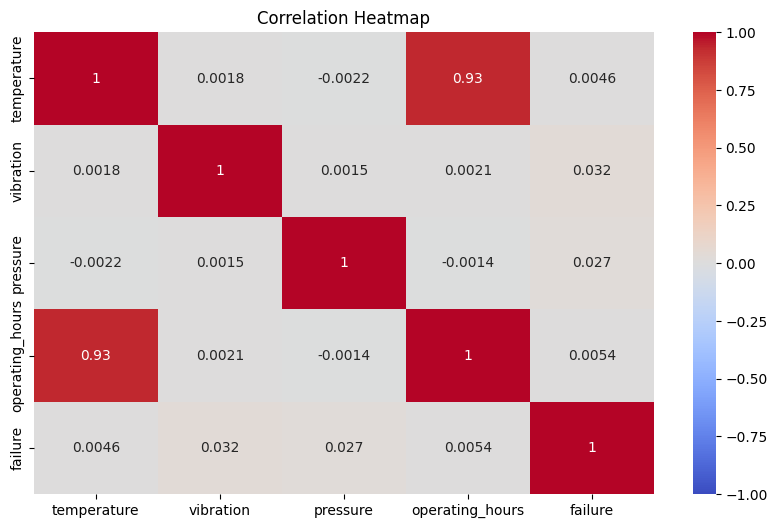

In [37]:
# Using correlation Heatmap to check for correlation between features

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
correlation = df[['temperature', 'vibration', 'pressure', 'operating_hours', 'failure']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

In [38]:
# Implement lag features for previous temperatures/vibration/pressure values
# Lag features help teach the model about how the past influences the future (very useful for time series data)

def create_lag_features(df, lag=3):
    df['temperature_lag'] = df['temperature'].shift(lag)
    df['vibration_lag'] = df['vibration'].shift(lag)
    df['pressure_lag'] = df['pressure'].shift(lag)
    df['timestamp_lag']=df['timestamp'].shift(lag)
    df.dropna(inplace=True)  # Drop rows with NaN created by lagging
    return df

df = create_lag_features(df)
len(df)

print(f'We are now keeping {len(df)} total equipment readings in the data base with past readings from 3 hours before')

We are now keeping 437997 total equipment readings in the data base with past readings from 3 hours before


In [39]:
df.head()

,timestamp,device_id,temperature,vibration,pressure,operating_hours,failure,temperature_lag,vibration_lag,pressure_lag,timestamp_lag
3,2024-09-19 00:50:05.143971,0,43.797792,5.644626,30.383726,4,0,76.365118,5.148076,18.722041,2024-09-18 21:50:05.143971
4,2024-09-19 01:50:05.143971,0,45.016747,5.299714,18.014743,5,0,66.651052,5.505549,31.403880,2024-09-18 22:50:05.143971
5,2024-09-19 02:50:05.143971,0,55.301966,4.281594,16.280505,6,0,44.356926,2.709734,22.699004,2024-09-18 23:50:05.143971
6,2024-09-19 03:50:05.143971,0,64.272741,4.901509,16.939119,7,0,43.797792,5.644626,30.383726,2024-09-19 00:50:05.143971
7,2024-09-19 04:50:05.143971,0,59.074123,7.415419,22.798577,8,0,45.016747,5.299714,18.014743,2024-09-19 01:50:05.143971


In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Setting features and target value
X = df[['temperature', 'vibration', 'pressure', 'operating_hours', 'temperature_lag', 'vibration_lag', 'pressure_lag']]
y = df['failure']

# Split data and standardize features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Random Forest: Supervised Machine Learning Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=2)
rf_model.fit(X_train_scaled, y_train)
y_pred = rf_model.predict(X_test_scaled)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     87591
           1       1.00      1.00      1.00         9

    accuracy                           1.00     87600
   macro avg       1.00      1.00      1.00     87600
weighted avg       1.00      1.00      1.00     87600

Confusion Matrix:
 [[87591     0]
 [    0     9]]
ROC AUC Score: 1.0


In [42]:
# Apply XGBoost to compare results. XGBoost should do better as it builds trees sequentially, fixing errors in previous models.

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

xgb_model = XGBClassifier(n_estimators=100, random_state=2)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_xgb))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     87591
           1       0.75      1.00      0.86         9

    accuracy                           1.00     87600
   macro avg       0.88      1.00      0.93     87600
weighted avg       1.00      1.00      1.00     87600

Confusion Matrix:
 [[87588     3]
 [    0     9]]
ROC AUC Score: 0.999982874952906



### Comparison of XGBoost and Random Forest Models

**1. Classification Report:**

- **Class 0 (Failure)**
  - Both models achieve perfect precision and recall for class 0, indicating effective identification of non-failures without mistakes.

- **Class 1 (Non-Failure)**
  - **XGBoost**:
    - **Precision**: 0.75 (75% of XGBoost's non-failure predictions are correct)
    - **Recall**: 1.00 (XGBoost identifies all actual non-failures correctly)
    - **F1-Score**: 0.86
  - **Random Forest**:
    - **Precision**: 1.00 (Perfect precision; all non-failure predictions are correct)
    - **Recall**: 1.00 (Random Forest identifies all actual non-failures correctly)
    - **F1-Score**: 1.00
    - Random Forest outperforms XGBoost with perfect precision and F1-Score for class 1.

- **Macro Average:**
  - **XGBoost**:
    - Precision: 0.88
    - Recall: 1.00
    - F1-Score: 0.93
  - **Random Forest**:
    - Precision: 1.00
    - Recall: 1.00
    - F1-Score: 1.00
    - Random Forest has higher macro averages, reflecting better performance in both precision and F1-Score for the non-failure class.

- **Weighted Average:**
  - Both models have perfect weighted averages, but Random Forest's perfect precision and recall contribute to a higher F1-Score and a slightly better overall performance.

**2. Confusion Matrix:**

- **XGBoost**:
  - Three false positives and no false negatives.
- **Random Forest**:
  - No false positives and no false negatives.
  - Random Forest has the advantage of perfect classification with no errors, while XGBoost has a few false positive errors.

**3. ROC AUC Score:**

- **XGBoost**: 0.999982874952906
- **Random Forest**: 1.0
  - Both models have very high ROC AUC scores, indicating excellent performance in distinguishing between classes. Random Forest has a perfect ROC AUC score, suggesting slightly better performance in separating classes.

### Summary

- **XGBoost** and **Random Forest** both perform exceptionally well, but there are clear differences:
  - **Random Forest** has perfect precision, recall, and F1-Score for the non-failure class, making it the superior model in this comparison.
  - **XGBoost** has very high performance but shows some limitations with a few false positives and slightly lower precision for class 1.

**Choosing Between Models:**
- **Random Forest** is preferred for its flawless precision and recall for non-failures and overall perfect performance metrics.
- **XGBoost** is still a strong performer but slightly less optimal in terms of precision and false positive errors. This could cause unexpected machine failures and lead to downtime of the system. Such cases would increase costs for the company in charge of the system.


## Next Steps: Implementing LSTM for Time Series Data

### Project Context

After achieving good results with Random Forest and XGBoost in predicting machine failures, we should consider leveraging the time series nature of our data. An LSTM (Long Short-Term Memory) model is well-suited for this task because it can capture temporal dependencies and trends over time.

### Why LSTM?

- **Temporal Patterns:** LSTMs excel at handling sequential data, making them ideal for our hourly machine readings over multiple days.
- **Enhanced Prediction:** They can uncover complex time-based patterns that might be missed by other models.

### Implementation Plan

1. **Prepare Data:**
   - Include lag features to account for past values.
   - Normalize the data for better performance.

2. **Build and Train the LSTM Model:**
   - Define an LSTM architecture to handle our time series data.
   - Train the model with early stopping to avoid overfitting.

3. **Evaluate and Predict:**
   - Assess model performance with metrics like accuracy, ROC AUC, and confusion matrix.
   - Adjust prediction thresholds as needed.

### Summary

Integrating an LSTM model will allow us to leverage the time series nature of our data more effectively, potentially improving our predictive maintenance capabilities and reducing unplanned downtimes.
